In [5]:
# pretrained network 생성
from tensorflow.keras.applications import VGG16

model_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150,150,3))
model_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [6]:
# Feature Extraction 작업

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/drive/MyDrive/Machine Learning Colab/CAT_DOG/cat_dog_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

datagen = ImageDataGenerator(rescale=1/255)
batch_size=20

def extract_feature(directory,sample_count):
    features = np.zeros(shape=(sample_count,4, 4, 512)) 
    labels = np.zeros(shape=(sample_count,))

    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary'
    )

    i = 0

    for x_data_batch, t_data_batch in generator:
        feature_batch = model_base.predict(x_data_batch)
        features[i*batch_size:(i+1)*batch_size] = feature_batch
        labels[i*batch_size:(i+1)*batch_size] = t_data_batch

        i += 1

        if i * batch_size >= sample_count:
            break
    
    return features, labels
    
train_features, train_labels = extract_feature(train_dir,2000)
validation_features, validation_labels = extract_feature(validation_dir,1000)    

Found 2004 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
# classifier

train_features = np.reshape(train_features, (2000,4*4*512))
validation_features = np.reshape(validation_features, (1000,4*4*512))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

model = Sequential()

model.add(Dense(256,
                activation='relu',
                input_shape=(4*4*512,)))
model.add(Dropout(0.5))
model.add(Dense(1,
                activation='sigmoid'))

model.compile(optimizer=RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features,
                    train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features,validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 5ms/step - loss: 0.7857 - accuracy: 0.5410 - val_loss: 0.4612 - val_accuracy: 0.8280
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.4792 - accuracy: 0.7853 - val_loss: 0.3668 - val_accuracy: 0.8630
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3669 - accuracy: 0.8310 - val_loss: 0.3321 - val_accuracy: 0.8640
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3303 - accuracy: 0.8563 - val_loss: 0.3005 - val_accuracy: 0.8900
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3110 - accuracy: 0.8745 - val_loss: 0.2893 - val_accuracy: 0.8830
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2689 - accuracy: 0.9008 - val_loss: 0.2747 - val_accuracy: 0.8950
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2458 - accuracy: 0.8906 - val_loss: 0.2805 - val_accuracy: 0.8820
Epoch 

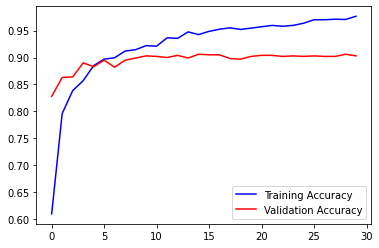

In [12]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_acc, color='b', label='Training Accuracy')
plt.plot(val_acc, color='r', label='Validation Accuracy')
plt.legend()
plt.show()

# plt.plot(train_loss, color='b', label='Training Loss')
# plt.plot(val_loss, color='r', label='Validation Loss')
# plt.legend()
# plt.show()


In [18]:
## 조금 더 나은 결과를 얻으려면..
## 데이터가 많아지면 조금 더 좋아질 거 같아요!!
## 증식을 포함.
## Pretrained Network과 우리 classifier를 합쳐서 모델을 만들꺼예요!

import os
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

base_dir = '/content/drive/MyDrive/Machine Learning Colab/CAT_DOG/cat_dog_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)

validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['cats', 'dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

## Pretrained Network
model_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150,150,3))

model_base.trainable = False   # Convolution Layer를 동결

model = Sequential()

model.add(model_base)

model.add(Flatten(input_shape=(4*4*512,)))

model.add(Dense(units=256,
                activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(units=1,
                activation='sigmoid'))

model.summary()

model.compile(optimizer=RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50)


Found 2004 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/30
100/1

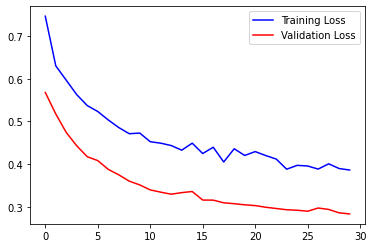

In [20]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# plt.plot(train_acc, color='b', label='Training Accuracy')
# plt.plot(val_acc, color='r', label='Validation Accuracy')
# plt.legend()
# plt.show()

plt.plot(train_loss, color='b', label='Training Loss')
plt.plot(val_loss, color='r', label='Validation Loss')
plt.legend()
plt.show()

In [23]:
#### Fine Tuning

import os
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

base_dir = '/content/drive/MyDrive/Machine Learning Colab/CAT_DOG/cat_dog_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)

validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['cats', 'dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

## Pretrained Network
model_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150,150,3))

model_base.trainable = False   # Convolution Layer를 동결

model = Sequential()

model.add(model_base)

model.add(Flatten(input_shape=(4*4*512,)))

model.add(Dense(units=256,
                activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(units=1,
                activation='sigmoid'))

model.summary()

model.compile(optimizer=RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50)

model_base.trainable = True

for layer in model_base.layers:
    if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3']:
        layer.trainable = True
    else:
        layer.trainable = False

# 일반적으로 learning_rate를 더 작게 설정
model.compile(optimizer=RMSprop(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50)


Found 2004 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/30
100/1